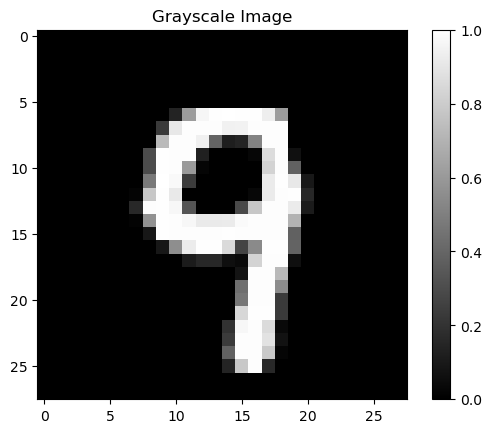

In [88]:
##Data processing and input

from PIL import Image
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

splits = {'train': 'mnist/train-00000-of-00001.parquet', 'test': 'mnist/test-00000-of-00001.parquet'}

##parquet files from hugging face

df_train = pd.read_parquet("hf://datasets/ylecun/mnist/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/ylecun/mnist/" + splits["test"])


n = len(df_train) #10000 samples

##initialize matrix
matrix = np.zeros((784, n))
for i in range(n):
    
    #Read bytes of the raw image
    image_bytes = df_train['image'][i].get('bytes')
    image_object = Image.open(io.BytesIO(image_bytes))
    pixel_values = np.array(image_object.getdata())
    matrix[:, i] = pixel_values / 255.

###For visualization of pixels and image
image_pixels = matrix[:, 520]

image_reshaped = image_pixels.reshape(28, 28)

plt.imshow(image_reshaped, cmap='gray', interpolation='nearest')
plt.title(f'Grayscale Image')
plt.colorbar()
plt.show()

In [89]:
x_train = matrix
y_train = np.array(df_train['label'].head(n))

print(x_train[:, 1].shape, y_train.shape)

(784,) (60000,)


In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F

##Torch tensors conversion
x_train = torch.tensor(x_train.T)
y_train = torch.tensor(y_train)

class simpleNN(nn.Module):
    def __init__(self):
        super(simpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 10)
        self.fc2 = nn.Linear(10, 10)
        
    def forward(self, X):
        Z1 = self.fc1(X)
        A1 = F.relu(Z1)
        Z2 = self.fc2(A1)
        A2 = F.softmax(Z2, dim=1)
        return A2
    
def one_hot_encode(Y, num_classes):
    return F.one_hot(Y, num_classes=num_classes).float()

def compute_loss(A2, Y):
    loss = F.cross_entropy(A2, Y)
    return loss

def train(model, X, Y, optimizer, num_iterations=100):
    for i in range(num_iterations):
        A2 = model(X)
        loss = compute_loss(A2, Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print(f'Iteration {i}, Loss: {loss.item()}')
            
model = simpleNN()
optimizer = torch.optim.SGD(model.parameters(), lr=0.12)


train(model, x_train.float(), y_train, optimizer, num_iterations=5000)
    

Iteration 0, Loss: 2.3021018505096436
Iteration 100, Loss: 2.2294692993164062
Iteration 200, Loss: 2.0262696743011475
Iteration 300, Loss: 1.8540387153625488
Iteration 400, Loss: 1.759088158607483
Iteration 500, Loss: 1.7147479057312012
Iteration 600, Loss: 1.6911100149154663
Iteration 700, Loss: 1.6765652894973755
Iteration 800, Loss: 1.6654446125030518
Iteration 900, Loss: 1.639023780822754
Iteration 1000, Loss: 1.621567964553833
Iteration 1100, Loss: 1.6101007461547852
Iteration 1200, Loss: 1.601802110671997
Iteration 1300, Loss: 1.5954276323318481
Iteration 1400, Loss: 1.590328335762024
Iteration 1500, Loss: 1.5861283540725708
Iteration 1600, Loss: 1.5825875997543335
Iteration 1700, Loss: 1.5795458555221558
Iteration 1800, Loss: 1.5768918991088867
Iteration 1900, Loss: 1.5745490789413452
Iteration 2000, Loss: 1.57245671749115
Iteration 2100, Loss: 1.5705746412277222
Iteration 2200, Loss: 1.5688683986663818
Iteration 2300, Loss: 1.5673120021820068
Iteration 2400, Loss: 1.56588494777

In [91]:
indices = np.random.choice(x_train.shape[0], 10, replace=False) ##Pick some random indices to test

x_test = x_train[indices, :]

In [92]:
y_test = y_train[indices]
print(y_test)

tensor([8, 6, 2, 2, 6, 0, 5, 3, 4, 1])


In [93]:
def inference(model, X):
    model.eval()
    
    with torch.no_grad():
        A2 = model(X.float())
        predictions = torch.argmax(A2, dim=1)
    
    return predictions

predictions = inference(model, x_test)
print("Predicted classes: ", predictions)
print("Actual classes: ", y_test)

correct_predictions = (predictions == y_test).sum().item()
total_predictions = len(predictions)
accuracy = correct_predictions / total_predictions

print(f"Accuracy: {accuracy*100:0.2f} %")


Predicted classes:  tensor([5, 6, 2, 2, 6, 0, 5, 3, 4, 1])
Actual classes:  tensor([8, 6, 2, 2, 6, 0, 5, 3, 4, 1])
Accuracy: 90.00 %
